### Preprocessing Raw data and some EDA
---
In this notebook we will:
- `Query raw data:` This could be equivalent to any processing pipeline from which we may produce our starting dataset.
- `Preprocessing Raw data and some EDA`: Process and filter the raw dataset

In [5]:
import lamindb as ln
import bionty as bt

→ connected lamindb: laminlabs/lamindata


In [6]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy.sparse as sp
from tqdm import tqdm

In [ ]:
ln.Project.df()

In [ ]:
ln.track(project="9M7iVOgQ8VAQ")

→ loaded Transform('WNVvHmeVnnxb0000'), re-started Run('TyOLdmyE...') at 2025-03-25 21:20:56 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.2 lamindb==1.3.0 pandas==2.2.3 scanpy==1.11.0 scipy==1.14.1 tqdm==4.67.1


Anyone looking to start the analysis from raw/unfiltered data can search the artifacts registry and retrieve the `.h5ad` file containing the raw counts.

In [ ]:
adata_artifact = ln.Artifact.get("grmr98C4DvA2ofeP0000")
adata_artifact

#getting error: OperationalError: connection to server at "database2.cmyfs24wugc3.us-east-1.rds.amazonaws.com" (3.211.54.97), port 5432 failed: Operation timed out
#	Is the server running on that host and accepting TCP/IP connections?

OperationalError: connection to server at "database2.cmyfs24wugc3.us-east-1.rds.amazonaws.com" (3.211.54.97), port 5432 failed: Operation timed out
	Is the server running on that host and accepting TCP/IP connections?


In [13]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'grmr98C4DvA2ofeP0000'
│   ├── .key = 'schema/raw_adata.h5ad'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = s3://lamindata/.lamindb/grmr98C4DvA2ofeP0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-20 21:49:35
│   └── .transform = 'Schema_001_V4.ipynb'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
└── Labels
    └── .projects                   Project                    Breast metastasis                        
        .tissues                    bionty.Tissue              lymph node, breast                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

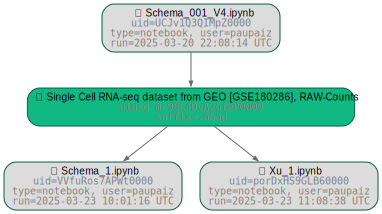

In [14]:
adata_artifact.view_lineage()

In [6]:
adata = adata_artifact.load()
adata

AnnData object with n_obs × n_vars = 117481 × 17872
    obs: 'patient', 'site'

### Preprocessing the dataset
---
A common step after receiving the raw data is preprocessing, which ensures data quality and prepares it for downstream analysis. In scRNA-seq, preprocessing typically involves quality control (QC), filtering, normalization, and transformation to remove technical artifacts and retain biologically meaningful signals.


As an analyst, starting from raw data every time can be inefficient and time-consuming. Instead, we may prefer to begin from an already preprocessed dataset, allowing us to focus more on analysis rather than repetitive data cleaning steps.

To enable this, we perform quality control (QC) and preprocessing on the raw data and save it as an artifact, tagging it as "preprocessed." This ensures that future analyses can directly access a clean and structured dataset without redoing the initial steps.

To maintain consistency and interoperability, we define a schema that the dataset must adhere to after preprocessing. This schema ensures that the data contains essential columns and metadata, such as:

Cell quality metrics (e.g., mitochondrial content, total counts, detected genes)
- Filtered gene expression values
- Cell annotations (if available)
- Batch information (if applicable)

By enforcing this structured approach, we ensure that the dataset remains well-organized, reproducible, and ready for downstream analysis, streamlining the overall workflow.

Below are some common preprocessing steps for a scRNA-seq data: 

#### A. Tagging MT genes, Mito Genes, HB genes 
---
In these preprocessing steps we annotate mitochondrial (MT-), ribosomal (RPS/RPL), and hemoglobin (HB) genes in single-cell RNA-seq data. 
- Mitochondrial genes indicate cell stress or apoptosis,
- ribosomal genes can reflect high transcriptional activity
- hemoglobin genes are often filtered in non-blood samples to avoid bias.

In the later steps we use these annotation to calculate quality metrics which will help filter out data.

In [7]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

#### B. Calculating Metrics based on the taggings:  
---
We calculate QC metrics for annotated mitochondrial (mt), ribosomal (ribo), and hemoglobin (hb) genes to evaluate data quality. 
We'll later plot these metrics which will enable us to decide on a cut-off value for filtering out the cells.

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### C. Plotting Metrics
---
We now generate violin plots to visualize key QC metrics: 
- the number of detected genes per cell (n_genes_by_counts)
- total UMI counts per cell (total_counts)
- percentage of mitochondrial gene expression (pct_counts_mt)

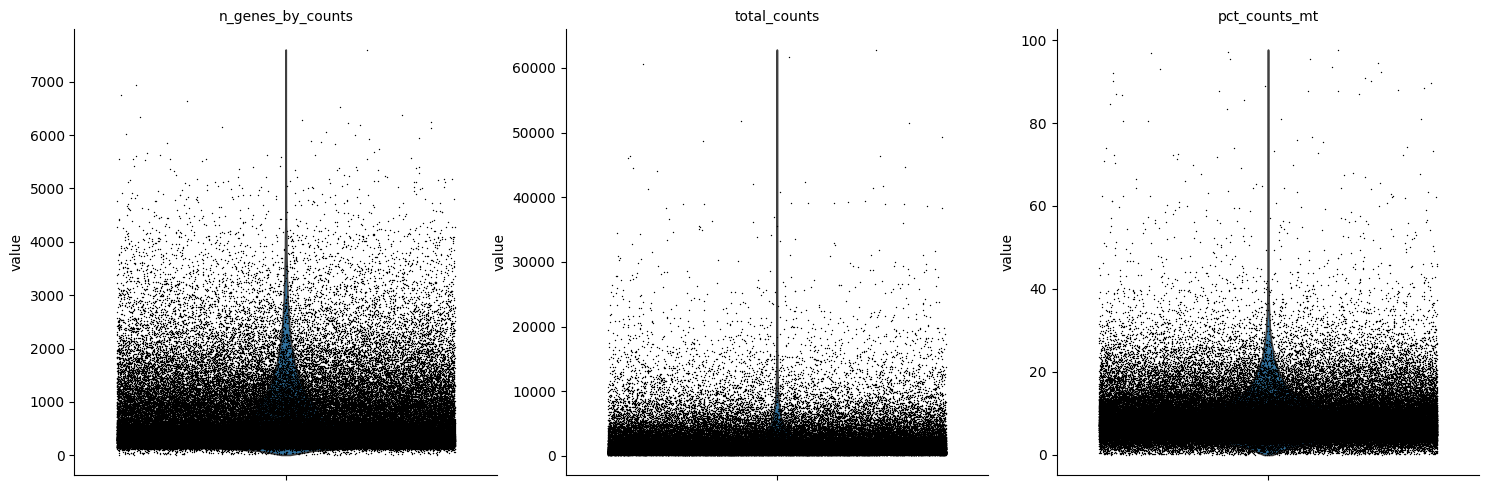

In [19]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

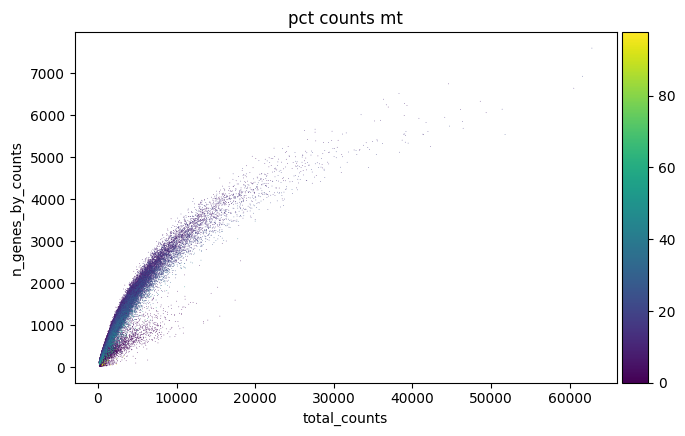

In [20]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### D. Defining and applying Filters
---
We can now filter out low-quality cells by removing those cells: 
- which have high mitochondrial content (>20%),
- low gene counts (<200),
- excessive gene expression (>2000, potential doublets),
- extreme total counts (<1000 or >30000).

This ensures a high-quality dataset by retaining biologically relevant cells.

In [9]:
# Define filtering thresholds
mt_threshold = 0.2  
min_genes_per_cell = 200  
max_genes_per_cell = 2000 
min_counts_per_cell = 1000  
max_counts_per_cell = 30000  

# Apply filters
filtered_cells = (
    (adata.obs["pct_counts_mt"] < mt_threshold * 100) &  
    (adata.obs["n_genes_by_counts"] > min_genes_per_cell) &
    (adata.obs["n_genes_by_counts"] < max_genes_per_cell) &
    (adata.obs["total_counts"] > min_counts_per_cell) &
    (adata.obs["total_counts"] < max_counts_per_cell)
)

# Filter the dataset
adata = adata[filtered_cells].copy()

print(f"Remaining cells after filtering: {adata.shape[0]}")

Remaining cells after filtering: 42049


In [10]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

#### E. Normalising and transforming the counts

In [11]:
adata.layers["counts"] = adata.X.copy()

We now normalize the data to 10,000 counts per cell (`normalize_total`) to correct for sequencing depth, apply log transformation (`log1p`) to stabilize variance, and select the top 2,000 highly variable genes (`highly_variable_genes`, `subset=True`) to retain the most informative features for downstream analysis.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

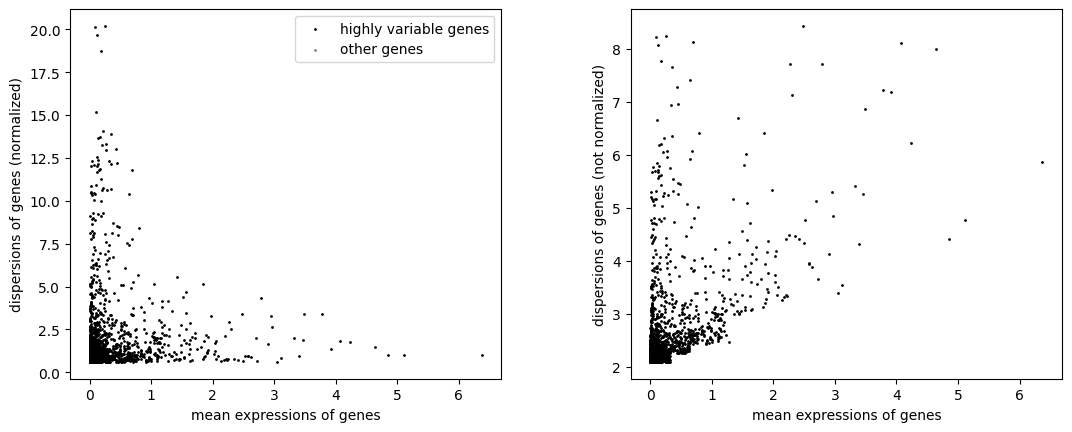

In [13]:
sc.pl.highly_variable_genes(adata)

### Saving AnnData After Preprocessing
---

After preprocessing, our `.var` and `.obs` dataframes contain additional columns, enriching the dataset with crucial metadata and annotations.

To maintain consistency and interoperability, any preprocessed dataset ingested into the LaminDB datalake should follow a predefined schema. This ensures that every analysis starts with the same essential set of information, eliminating inconsistencies and improving reproducibility.

In the next few steps, we will explore:

- What schemas are
- How to define a schema for an AnnData object
- How to enforce schema adherence when registering an artifact

By structuring our datasets effectively, we create a standardized and interoperable data pipeline, making analysis more efficient and scalable

Let's have a look at our annData object now

In [26]:
adata.var.head()

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
SPP1,False,False,False,2923,0.430912,0.358312,97.511938,50624,10.832201,2059,True,1.560116,6.012944,4.681798
HLA-DPB1,False,False,False,27577,0.638656,0.493877,76.526417,75030,11.225657,13625,True,1.910738,3.399993,1.125622
MT-RNR2,True,False,False,116483,34.280113,3.563319,0.849499,4027262,15.208598,41967,True,5.113736,4.774937,1.000000
IGLC2,False,False,False,27936,7.435526,2.132452,76.220836,873533,13.680302,12323,True,4.065498,8.115295,1.832363
IGLC3,False,False,False,12000,2.112044,1.135280,89.785582,248125,12.421692,5273,True,2.788179,7.707479,4.329275


In [27]:
adata.obs.head()

,patient,site,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes
TTGCTGAAGTGC-0,P1,primary,906,6.810142,6283,8.745762,80.725768,83.893045,87.712876,93.538119,239,5.480639,3.803915,152,5.030438,2.419226,0,0.000000,0.000000,906
CGACAGGTGAGG-0,P1,primary,1850,7.523481,7304,8.896314,50.177985,58.064074,66.511501,78.628149,950,6.857514,13.006572,826,6.717805,11.308872,0,0.000000,0.000000,1850
ATCAAGCCTATT-0,P1,primary,1607,7.382746,6982,8.851234,61.400745,66.327700,72.543684,82.769980,295,5.690359,4.225150,379,5.940171,5.428244,0,0.000000,0.000000,1607
ATGCCTACATGG-0,P1,primary,779,6.659294,5448,8.603187,81.424376,84.691630,88.656388,94.878855,412,6.023448,7.562408,192,5.262690,3.524229,0,0.000000,0.000000,779
CTTATATGCTTA-0,P1,primary,1936,7.568896,6550,8.787373,38.259542,47.022901,57.038168,72.992366,506,6.228511,7.725191,394,5.978886,6.015267,4,1.609438,0.061069,1936


#### We can now create a schema for our annData objects and use it validate.
---
Here we will define a few labels and features that we see in the obs/var columns of the annData Object.

#### A. Define Lables

In [14]:
## Defining the ULabels
## We have the following we saw a categorical and with limited set of values
patient_ulabel = ln.ULabel(name="Patient", is_type=True).save()
site_ulabel = ln.ULabel(name="Site", is_type=True).save()

→ returning existing ULabel record with same name: 'Patient'
→ returning existing ULabel record with same name: 'Site'


In [29]:
ln.ULabel.df().head()

,uid,name,is_type,description,reference,reference_type,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,
290,zpbXAeGF,Site,True,None,None,None,1,NaN,538.0,2025-03-20 22:40:04.055998+00:00,35,None,1
289,JX2kXxtv,Patient,True,None,None,None,1,NaN,538.0,2025-03-20 22:40:03.372147+00:00,35,None,1
288,uG1YjmBo,Filtered,False,None,None,None,1,286.0,536.0,2025-03-20 22:17:47.285336+00:00,35,None,1
287,v2mUqrXx,Raw,False,None,None,None,1,286.0,536.0,2025-03-20 22:17:46.992109+00:00,35,None,1
286,90aLkbDj,Processing Stage,True,None,None,None,1,NaN,536.0,2025-03-20 22:17:41.379232+00:00,35,None,1


#### B. Define Features
---
Here, we will define the Features using the ULabels we have defined eariler.

`patient`, `site` and other calculated values.

In [15]:
# Note that we have defined cat features with the categorical ULabel[Patient]
# These are features for the obs dataframe
f_1 = ln.Feature(name="patient", dtype="cat[ULabel[Patient]]").save()
f_2 = ln.Feature(name="Site", dtype="cat[ULabel[Site]]").save()
f_3 = ln.Feature(name="n_genes_by_counts", dtype="int").save()
f_4 = ln.Feature(name="log1p_n_genes_by_counts", dtype="float").save()

→ returning existing Feature record with same name: 'patient'
→ returning existing Feature record with same name: 'Site'
→ returning existing Feature record with same name: 'n_genes_by_counts'
→ returning existing Feature record with same name: 'log1p_n_genes_by_counts'


In [16]:
# These are features for the var Dataframe
f_5 = ln.Feature(name="mt", dtype="bool").save()
f_6 = ln.Feature(name="ribo", dtype="bool").save()
f_7 = ln.Feature(name="hb", dtype="bool").save()
f_8 = ln.Feature(name="n_cells_by_counts", dtype="int").save()
f_9 = ln.Feature(name="mean_counts", dtype="float").save()

→ returning existing Feature record with same name: 'mt'
→ returning existing Feature record with same name: 'ribo'
→ returning existing Feature record with same name: 'hb'
→ returning existing Feature record with same name: 'n_cells_by_counts'
→ returning existing Feature record with same name: 'mean_counts'


We can now see the registered Features in lamindb's registry.

In [43]:
ln.Feature.df().head()

,uid,name,dtype,is_type,unit,description,array_rank,array_size,array_shape,proxy_dtype,synonyms,_expect_many,_curation,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,
490,irnHIUReZzjj,Site,cat[ULabel[Site]],None,None,None,0,0,None,None,None,True,None,1,None,540.0,2025-03-23 12:05:29.056554+00:00,35,"{'af': {'0': None, '1': True, '2': False}}",1
489,2Mj0otgnhuuP,mean_counts,float,None,None,None,0,0,None,None,None,True,None,1,None,538.0,2025-03-20 22:45:02.349383+00:00,35,"{'af': {'0': None, '1': True, '2': False}}",1
488,8KVxTPBLoGcS,n_cells_by_counts,int,None,None,None,0,0,None,None,None,True,None,1,None,538.0,2025-03-20 22:45:01.677540+00:00,35,"{'af': {'0': None, '1': True, '2': False}}",1
487,OVzm1R3PfR9W,hb,bool,None,None,None,0,0,None,None,None,True,None,1,None,538.0,2025-03-20 22:45:01.026810+00:00,35,"{'af': {'0': None, '1': True, '2': False}}",1
486,ZjUHGQhleNTu,ribo,bool,None,None,None,0,0,None,None,None,True,None,1,None,538.0,2025-03-20 22:45:00.288413+00:00,35,"{'af': {'0': None, '1': True, '2': False}}",1


Now we define the **schema** for the `.obs` and `.var` dataframes for our anndata:  

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" alt="AnnData Schema" width="600">


#### C. Define Schema for Obs DataFrame

In [17]:
# Obs Dataframe Schema
obs_schema = ln.Schema(
    name="Obs Dataframe Schema after preprocessing",
    otype="DataFrame",
    features=[
        f_1,
        #f_2,
        f_3,
        f_4
    ],
    coerce_dtype=True
).save()

→ returning existing schema with same hash: Schema(uid='w0RGEtgVihI1cvVF5xLR', name='Obs Dataframe Schema after preprocessing', n=3, itype='Feature', is_type=False, otype='DataFrame', hash='omn1FV03K6dG4Sf72SB-Cg', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=35, run_id=538, created_at=2025-03-20 22:51:42 UTC)


#### D. Define Schema for Var DataFrame

In [18]:
var_schema = ln.Schema(
    name="Var Dataframe Schema after preprocessing",
    otype="DataFrame",
    features=[
        f_5,
        f_6,
        f_7,
        f_8,
        f_9
    ],
    coerce_dtype=True
).save()

→ returning existing schema with same hash: Schema(uid='ge0tAYSrVVTjsVCFwgXb', name='Var Dataframe Schema after preprocessing', n=5, itype='Feature', is_type=False, otype='DataFrame', hash='AIqOJ866LV29WcGAzvc28A', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=35, run_id=538, created_at=2025-03-20 22:51:47 UTC)


#### E. Define Schema for the AnnData Object

In [19]:
adata_schema = ln.Schema(
    name="Preprocessed AnnData schema",
    otype="AnnData",
    components={
        "obs":obs_schema,
        "var":var_schema
    }
).save()

→ returning existing schema with same hash: Schema(uid='fQP0XU9nFFNFbCKlIy4d', name='Preprocessed AnnData schema', n=-1, dtype='num', itype='Composite', is_type=False, otype='AnnData', hash='YBSjkDIRM5RGNLMxrAFq7w', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=35, run_id=538, created_at=2025-03-20 22:51:51 UTC)


### Ensuring Datasets Adhere to a Schema
---
Now that we have defined a schema, we want to ensure that all preprocessed datasets conform to it, maintaining consistency and standardization across analyses.

We achieve this using the curator method in LaminDB, which validates whether the values in the dataset align with the defined schema constraints. This ensures that:

- Required columns and metadata are present
- Data types and value ranges are consistent
- The dataset structure remains uniform across different analyses

#### A. Define a curator object using the dataset(AnnData) and schema

In [20]:
curator = ln.curators.AnnDataCurator(
    adata,
    adata_schema
)

In [21]:
try:
    curator.validate()
except ln.errors.ValidationError as error:
    print(error)

✓ "patient" is validated against ULabel.name
column 'mt' not in dataframe. Columns in dataframe: ['SPP1', 'HLA-DPB1', 'MT-RNR2', 'IGLC2', 'IGLC3', 'A2M', 'FTL', 'MALAT1', 'IGKC', 'IGHG4', 'TXN', 'HSP90AA1', 'S100P', 'CXCL9', 'IGLC7', 'RGS1', 'RPS27', 'APOC1', 'COL3A1', 'TYROBP', 'IGHG1', 'CD74', 'IGHM', 'ETFBKMT', 'CD2', 'CST3', 'CCL4L2', 'CCL4', 'S100A8', 'TREM1', 'BEX5', 'ISG15', 'SRGN', 'IGFBP7', 'IKZF2', 'GPNMB', 'CAMP', 'HLA-DRB6', 'RNU2-63P', 'S100A4', 'IFI27', 'C3', 'ID2', 'CILP', 'INHBA', 'CEP55', 'PRSS23', 'CCL5', 'C1S', 'PALMD', 'ARAP2', 'PDE4B', 'SFRP2', 'CCR7', 'BIRC3', 'COL1A2', 'MX1', 'APOD', 'SGK1', 'EREG', 'BTG2', 'MT1X', 'ANXA1', 'AIF1', 'HLA-DPA1', 'C1R', 'IGHV1-69', 'CPVL', 'TRMT10B', 'MZB1', 'LY86', 'IFI44L', 'RNASE1', 'IL7R', 'LGALS1', 'GPR183', 'MMP7', 'AREG', 'SAMSN1', 'EEF1A1P3', 'MGP', 'MS4A7', 'CSTB', 'ZNF331', 'MYLK', 'FLT1', 'TEX9', 'TNFSF10', 'MT1F', 'CCL2', 'TNIP3', 'ADM', 'RF00003', 'MUCL1', 'AL357060.1', 'CREM', 'TOP2A', 'MAP3K8', 'EPSTI1', 'CKAP2', 'S10

We observe that the terms for certain fields, such as:

- patient
- site

are not yet validated.

To ensure consistency and standardization, we can assign ULabels to these features, defining them according to our expectations. Additionally, we can enhance validation and interoperability by leveraging public ontologies through Bionty, mapping these fields to standardized biomedical terminologies. This helps maintain a structured and universally interpretable dataset, improving both data quality and integration across different analyses

#### B. Defining Values for ULabels for ULable Type Patient and Site

In [22]:
curator_new = ln.Curator.from_anndata(
    adata,
    var_index=bt.Gene.ensembl_gene_id,
    categoricals={
        adata.obs.patient.name: ln.ULabel.name,
        adata.obs.site.name: ln.ULabel.name
    },
    organism="human",
)

In [23]:
try:
    curator_new.validate()
except ln.errors.ValidationError as error:
    print(error)

• mapping "var_index" on Gene.ensembl_gene_id
!   1392 terms are not validated: 'SPP1', 'MT-RNR2', 'IGLC2', 'IGLC3', 'IGKC', 'IGHG4', 'IGLC7', 'APOC1', 'COL3A1', 'TYROBP', 'IGHG1', 'ETFBKMT', 'S100A8', 'TREM1', 'BEX5', 'CAMP', 'HLA-DRB6', 'RNU2-63P', 'CILP', 'C1S', ...
    → fix typos, remove non-existent values, or save terms via .add_new_from_var_index()
✓ "patient" is validated against ULabel.name
✓ "site" is validated against ULabel.name


We see that we have 
- 1192 terms are not validated for var index
- 5 terms not validated for patient
- 3 terms are not validated for site

We can add those terms directly as:

In [ ]:
curator_new.add_new_from_var_index()
# note: # we are not including the 16 columns that are not validated below to keep the schema definition succinct

In [25]:
curator_new.add_new_from("patient")
curator_new.add_new_from("site")

In [ ]:
adata_artifact_curated = curator_new.save_artifact()

In [ ]:
adata_artifact_curated.describe()

### We can annotate our processed adata artifact with labels and Features
---

#### Labels

In [ ]:
## now annotate it as Filtered
filtered_status = ln.ULabel.get(name="Filtered")

In [ ]:
# add this raw Label to the artifact
adata_artifact_curated.ulabels.add(filtered_status)

In [ ]:
adata_artifact_curated.describe()

Similary we can add ULabels from bionty registry

In [ ]:
# Tissue
tissue_breast = bt.Tissue.from_source(name="breast").save()
tissue_lymph = bt.Tissue.from_source(name="lymph node").save()

adata_artifact_curated.tissues.add(tissue_breast)
adata_artifact_curated.tissues.add(tissue_lymph)

# Disease 
disease = bt.Disease.from_source(name="breast cancer").save()
adata_artifact_curated.diseases.add(disease)

In [ ]:
adata_artifact_curated.describe()

#### Features

We can also annotate datasets by features. Here we are reusing the features we had defined earlier.

In [53]:
# we can now annotate our artifact
adata_artifact_curated.features.add_values(
    {
        "experiment": "Breast Cancer scRNA-seq Experiment",
        "disease": disease,
        "author": "Xu K"
    }
)

Maybe we want to add a few more features

In [ ]:
ln.Feature(name="n_obs", dtype=int).save()
ln.Feature(name="n_genes", dtype=int).save()

In [56]:
# we can now annotate our artifact
adata_artifact_curated.features.add_values(
    {
        "n_obs": adata.shape[0],
        "n_genes": adata.shape[1],
    }
)

In [ ]:
adata_artifact_curated.describe()

In [ ]:
adata_artifact_curated.view_lineage()

In [ ]:
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

In [ ]:
project = ln.Project(name="Breast Cancer scRNA-seq Project")

We see that our artifacts are all saved under the project

In [ ]:
project.artifacts.df()

In [27]:
ln.finish()

• please hit CMD + s to save the notebook in your editor .. ✓
! cells [(5, 13), (14, 6), (8, 19), (20, 9), (13, 26), (27, 14), (14, 29), (29, 15), (16, 43), (43, 17), (23, None), (None, 25), (25, None), (None, None), (None, 46), (47, None), (None, None), (None, None), (None, 53), (53, None), (None, 56), (56, None), (None, None), (None, None), (None, None)] were not run consecutively
→ finished Run('TyOLdmyE') after 4m at 2025-03-25 21:25:54 UTC
→ go to: https://lamin.ai/laminlabs/lamindata/transform/WNVvHmeVnnxb0000
→ to update your notebook from the CLI, run: lamin save /Users/paulinampaiz/Desktop/myLamin_local/Xu_2.ipynb
